In [1]:
import pandas as pd
import numpy as np 
import scipy
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10,6)

# 1. Model definitions

In [2]:
class NotFittedError(BaseException):
    pass

### Logistic regression definition 

In [3]:
class LR():
    
    def __init__(self):
        self.theta_final = None
        self.log_l_history = None
    

    def __sigmoid(self, x):    
        g=1/(1+np.exp(-x))
        return g

    def __gradient_descent(self, theta, features, target, lr, num_steps):
        log_likelihood_history = np.zeros(num_steps)
        for step in range(num_steps):
            # compute and store the log_likelihood value
            hypothesis = self.__sigmoid(theta.dot(features.T))
            log_likelihood_history[step] = np.sum(target*np.log(hypothesis)+(1-target)*np.log(1-hypothesis))/features.shape[0]
            #update theta to do the gradient descent 
            theta -= lr * (-np.sum((target - self.__sigmoid(theta.dot(features.T)))[:,np.newaxis] * features, axis=0) / features.shape[0])
        return theta, log_likelihood_history
    
    def fit(self, x_train, y_train, theta0 = None, lr=0.5, num_steps=3000):
        if theta0 is None:
            # Initialize theta0
            theta0 = np.ones(x_train.shape[1])
        # Run Gradient Ascent method
        self.theta_final, self.log_l_history = self.__gradient_descent(theta0, x_train, y_train, lr=lr, num_steps=num_steps)

    def predict_proba(self, x_test):
        if self.theta_final is None:
            raise NotFittedError("Model not fitted, please call the fit method.")
        return np.array([self.__sigmoid(self.theta_final.dot(sample.T)) for sample in x_test])
        
    def predict(self, x_test, threshold=0.5):
        return np.where(self.predict_proba(x_test) >= threshold, 1, 0)

    def score(self, x_test, y_test, threshold=0.5):
        predictions = self.predict(x_test, threshold)
        return np.sum(predictions == y_test)/y_test.shape[0]

### Naive Bayes definition

In [4]:
class BernoulliNaiveBayes():

    
    def __init__(self):
        self.fitted = False
  

    def fit(self, x_train, y_train):
        self.fitted = False
        self.x_train, self.y_train = x_train, y_train
        self.n_samples, self.n_features = x_train.shape
        self.features_count = np.zeros((2, self.n_features))
        for cls in [0,1]:
            self.features_count[cls] = np.sum(x_train[y_train==cls], axis=0)
        self.fitted = True
        
        
    # P(Y)
    def __prior(self, cls):
        return np.sum(self.y_train==cls)/self.n_samples
        
        
    # P(X_i | Y_i)
    def __feature_likelihood(self, x_i, i, cls, alpha=0.1):
        p = (self.features_count[cls,i]) / (np.sum(self.y_train==cls))
        return (p**x_i) * ((1-p)**(1-x_i))
    
    
    # P(X | Y_i)
    def __likelihood(self, x, cls):
        return np.prod([self.__feature_likelihood(x[i],i,cls) for i in range(self.n_features)])
    
    
    # P(Y | X)
    def __posterior(self, x):
        total_prob = np.sum([self.__likelihood(x,cls)*self.__prior(cls) for cls in [0,1]]) 
        return self.__likelihood(x,1)*self.__prior(1)/total_prob
    
    
    def predict_proba(self, X_test):
        if not self.fitted:
            raise NotFittedError("Model not fitted, please call the fit method.")
        return np.array([self.__posterior(sample) for sample in X_test])
        
    
    def predict(self, X_test, threshold=0.5):
        return np.where(self.predict_proba(X_test) < threshold, 0, 1)
    
    
    def score(self, X_test, Y_test, threshold=0.5):
        predictions = self.predict(X_test, threshold)
        return np.sum(predictions == Y_test) / np.sum(Y_test.shape[0])

# 2. Data preparation

In [5]:
df = pd.read_csv("covid_early_stage_symptoms.csv")
df.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,SARS-CoV-2 Positive
0,male,89,1,1,0,0,0,0,0,1,0,0
1,male,68,1,0,0,0,0,0,0,0,0,0
2,male,68,0,0,0,0,0,0,0,1,0,0
3,male,68,1,1,0,0,0,0,0,1,1,1
4,male,50,1,1,1,0,1,0,0,1,0,1


In [6]:
df['gender'].loc[df['gender'] == 'male'] = 0
df['gender'].loc[df['gender'] == 'female'] = 1

df['age_year'] = df['age_year'].apply(lambda x: 0 if x < 40 else 1)

df.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,SARS-CoV-2 Positive
0,0,1,1,1,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0,0
3,0,1,1,1,0,0,0,0,0,1,1,1
4,0,1,1,1,1,0,1,0,0,1,0,1


In [7]:
df.groupby('SARS-CoV-2 Positive').describe()

age_year                                               \
                       count      mean       std  min  25%  50%  75%  max   
SARS-CoV-2 Positive                                                         
0                     4940.0  0.571457  0.494918  0.0  0.0  1.0  1.0  1.0   
1                     1572.0  0.618321  0.485953  0.0  0.0  1.0  1.0  1.0   

                      fever            ... travel_history       \
                      count      mean  ...            75%  max   
SARS-CoV-2 Positive                    ...                       
0                    4940.0  0.290081  ...            1.0  1.0   
1                    1572.0  0.790076  ...            1.0  1.0   

                    isolation_treatment                                     \
                                  count      mean       std  min  25%  50%   
SARS-CoV-2 Positive                                                          
0                                4940.0  0.162348  0.368807  0.0  0.0  0.0   
1                                1572.0  0.388677  0.487605  0.0  0.0  0.0   

                               
                     75%  max  
SARS-CoV-2 Positive            
0                    0.0  1.0  
1                    1.0  1.0  

[2 rows x 80 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6512 entries, 0 to 6511
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               6512 non-null   object
 1   age_year             6512 non-null   int64 
 2   fever                6512 non-null   int64 
 3   cough                6512 non-null   int64 
 4   runny_nose           6512 non-null   int64 
 5   muscle_soreness      6512 non-null   int64 
 6   pneumonia            6512 non-null   int64 
 7   diarrhea             6512 non-null   int64 
 8   lung_infection       6512 non-null   int64 
 9   travel_history       6512 non-null   int64 
 10  isolation_treatment  6512 non-null   int64 
 11  SARS-CoV-2 Positive  6512 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 610.6+ KB


In [9]:
X = df.drop(['SARS-CoV-2 Positive'], axis = 1, inplace = False).to_numpy(dtype = float)
y = df['SARS-CoV-2 Positive'].to_numpy(dtype = int)
# normalize
Z = preprocessing.StandardScaler().fit_transform(X) 
# ACP
pca = PCA(n_components=Z.shape[1])
A = pca.fit_transform(Z)

# 3. Training

### Fitting logistic regression

In [10]:
# Logistic regression
x_train_lr,x_test_lr,y_train_lr,y_test_lr=train_test_split(A,y,random_state=4,test_size=0.2)
lr = LR()
lr.fit(x_train_lr, y_train_lr)
print(lr.theta_final)

[ 3.94053626 -2.6519548  -0.37840316 -0.03193018 -0.14950299  0.43323285
  0.33020429 -0.17880723 -0.52283004  0.22327703 -5.12981778]


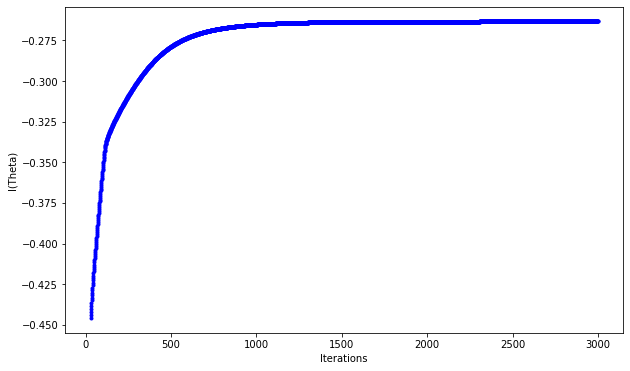

In [11]:
fig,ax = plt.subplots(num=2)

ax.set_ylabel('l(Theta)')
ax.set_xlabel('Iterations')
_=ax.plot(range(len(lr.log_l_history)),lr.log_l_history,'b.')

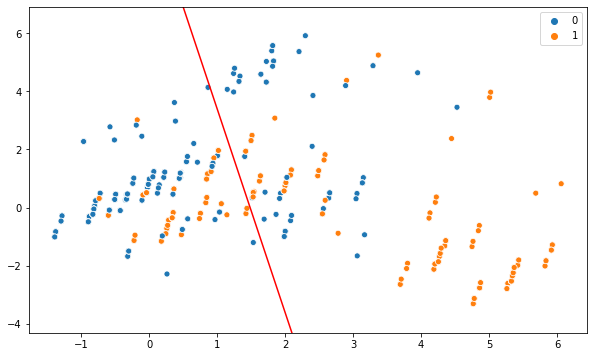

In [12]:
# Generate vector to plot decision boundary
x1_vec = np.linspace(x_train_lr[:,0].min(),x_train_lr[:,1].max(),2)

# Plot raw data
sns.scatterplot(x=x_train_lr[:,0], y=x_train_lr[:,1], hue=y_train_lr)

# Plot decision boundary
plt.plot(x1_vec,(-x1_vec*lr.theta_final[1]-lr.theta_final[0])/lr.theta_final[2], color="red")
plt.ylim(x_train_lr[:,1].min()-1,x_train_lr[:,1].max()+1)
# Save the theta_final value for later comparisons
theta_GA = lr.theta_final.copy()

### Fitting multinomial logistic regression

In [13]:
Z = preprocessing.StandardScaler().fit_transform(X) # normalize

pca = PCA(n_components=2)
A = pca.fit_transform(Z)

A = np.hstack([np.ones((A.shape[0], 1)), A])

In [14]:
def new_features(x, degree=2):
    # represent the vector x0 of ones
    features = np.ones(x[:,1].shape[0])
    #store and stack at the right the vectors x1 and x2 (with the right shape)
    x1,x2 = x[:,1], x[:,2]
    features = np.hstack([features.reshape(features.shape[0], 1), x1.reshape(x1.shape[0], 1)])
    features = np.hstack([features, x2.reshape(x2.shape[0], 1)])

    # for each degree (2 or 3 or more) we stack every possible combination between x1 and x2 (sum of powers = degree = i)
    for i in range(2, degree+1):
        for j in range(i+1) :
            x=(x1**(i-j))*(x2**(j))
            features = np.hstack([features, x.reshape(x.shape[0], 1)])
    
    return features

In [15]:
x_new_quad = new_features(A, degree=2)
x_new_cubic = new_features(A, degree=3)

#reordering output features
temp = np.copy(x_new_quad[:, -1])
x_new_quad[:, -1] = x_new_quad[:, -2]
x_new_quad[:, -2] = temp

temp = np.copy(x_new_cubic[:, -1])
x_new_cubic[:, -1] = x_new_cubic[:, -2]
x_new_cubic[:, -2] = x_new_cubic[:, -3]
x_new_cubic[:, -3] = temp

x_train_quad,x_test_quad,y_train_quad,y_test_quad=train_test_split(x_new_quad,y,random_state=4,test_size=0.2)
x_train_cubic,x_test_cubic,y_train_cubic,y_test_cubic=train_test_split(x_new_cubic,y,random_state=4,test_size=0.2)

In [16]:
# Initialize theta0, in case of quadratic features
theta0_quad = np.zeros(x_train_quad.shape[1])

lr2 = LR()
lr2.fit(x_train_quad, y_train_quad, theta0=theta0_quad, lr=0.01)

# Initialize theta0, in case of quadratic and cubic features
theta0_cubic = np.zeros(x_train_cubic.shape[1])

lr3 = LR()
lr3.fit(x_train_cubic, y_train_cubic, theta0=theta0_cubic, lr=0.01)

# check and compare with previous results
print(lr2.theta_final)
print(lr3.theta_final)

[-0.97631862  1.66766374 -0.11914946 -0.1651253  -0.09291426 -0.16892655]
[-0.64375005  1.25118884 -0.08125503 -0.82990586  0.02494826  0.00821261
  0.17632106 -0.16114057  0.06394702  0.17548766]


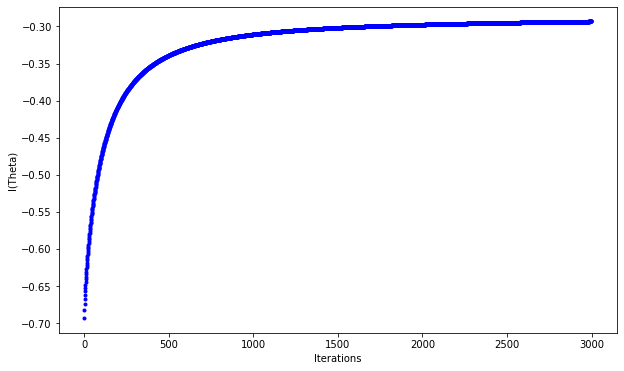

In [17]:
# Plot the log likelihood values in the optimization iterations, in one of the two cases.
fig,ax = plt.subplots(num=2)

ax.set_ylabel('l(Theta)')
ax.set_xlabel('Iterations')
_=ax.plot(range(len(lr2.log_l_history)),lr2.log_l_history,'b.')

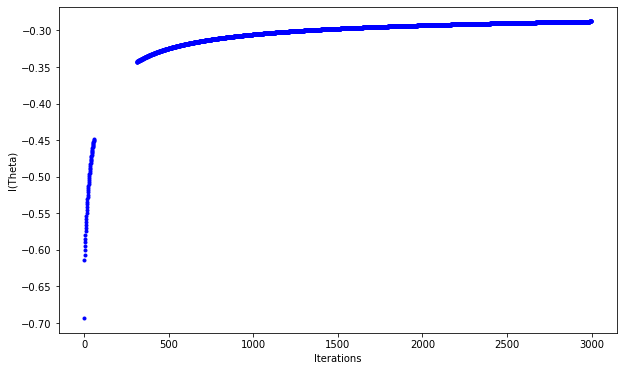

In [18]:
# Plot the log likelihood values in the optimization iterations, in one of the two cases.
fig,ax = plt.subplots(num=2)

ax.set_ylabel('l(Theta)')
ax.set_xlabel('Iterations')
_=ax.plot(range(len(lr3.log_l_history)),lr3.log_l_history,'b.')

In [19]:
def boundary_function(x1_vec, x2_vec, theta_final):
    
    x1_vec, x2_vec = np.meshgrid(x1_vec,x2_vec)
    x1 = x1_vec
    x2 = x2_vec
    
    if len(theta_final) == 6:
        # boundary function value for features up to quadratic
        c_0, c_1, c_2, c_3, c_4, c_5 = theta_final
        f = c_0 + c_1*x1 + c_2*x2 + c_3*(x1**2) + c_4*(x2**2) + c_5*x1*x2
    elif len(theta_final) == 10:
        # boundary function value for features up to cubic
        c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9 = theta_final
        f = c_0 + c_1*x1 + c_2*x2 + c_3*(x1**2) + c_4*(x2**2) + c_5*x1*x2 + c_6*(x1**3) + c_7*(x2**3) + c_8*(x1**2)*x2+ c_9*x1*(x2**2)
    else:
        raise("Number of Parameters is not correct")
        
    return x1_vec, x2_vec, f

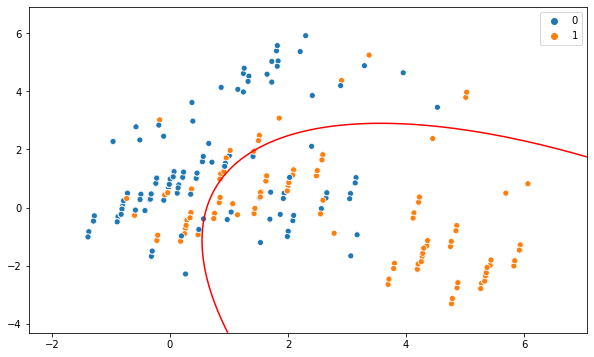

In [20]:
x1_vec = np.linspace(x_train_quad[:,1].min()-1,x_train_quad[:,1].max()+1,200);
x2_vec = np.linspace(x_train_quad[:,2].min()-1,x_train_quad[:,2].max()+1,200);

x1_vec, x2_vec, f = boundary_function(x1_vec, x2_vec, lr2.theta_final)

sns.scatterplot(x=x_train_quad[:,1], y=x_train_quad[:,2], hue=y_train_quad);

plt.contour(x1_vec, x2_vec, f, colors="red", levels=[0])
plt.show()

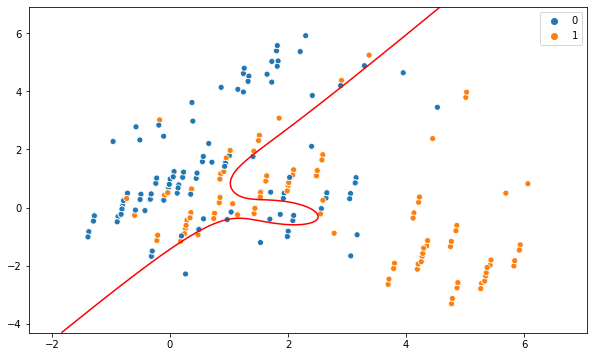

In [21]:
x1_vec = np.linspace(x_train_cubic[:,1].min()-1,x_train_cubic[:,1].max()+1,200);
x2_vec = np.linspace(x_train_cubic[:,2].min()-1,x_train_cubic[:,2].max()+1,200);

x1_vec, x2_vec, f = boundary_function(x1_vec, x2_vec, lr3.theta_final)

sns.scatterplot(x=x_train_cubic[:,1], y=x_train_cubic[:,2], hue=y_train_cubic);

plt.contour(x1_vec, x2_vec, f, colors="red", levels=[0])
plt.show()

### Fitting naive Bayes

In [22]:
x_train_nb,x_test_nb,y_train_nb,y_test_nb=train_test_split(X,y,random_state=4,test_size=0.2)

model = BernoulliNaiveBayes()
model.fit(x_train_nb, y_train_nb)

# 4. Performance
### Confusion Matrix, Accuracy and Recall

We compute confusion matrix for each model we made to compare their performance. 
Then, we do a score-based evaluation by computing the sensitivity (a.k.a recall) and accuracy.

\begin{bmatrix}
TP & FP  \\
FN & TN 
\end{bmatrix}

$Accuracy = \frac{TP + TN}{m}$ from all the classes (Positive and Negative), how many we predicted correctly?

$Recall = \frac{TP}{TP + FN}$ from the positive classes, how many we predicted correctly? (Sensitivity, True positive Rate)

$Specificity = \frac{TN}{TN + FP}$ from the negative classes, how many we predicted correclty (True negative rate)

$Precision = \frac{TP}{TP + FP}$ from all the classes we predicted as positive, how many are actually positive?


In [23]:
# Confusion matrices
cms = {}

def accuracy(cm):
    return (cm[0,0] + cm[1,1]) / np.sum(cm)

def recall(cm):
    return cm[0,0]/(cm[0,0] + cm[1,0])

def specificity(cm):
    return cm[1,1]/(cm[1,1] + cm[0,1])

def precision(cm):
    return cm[0,0]/(cm[0,0] + cm[0,1])

def f1_score(cm):
    p, r = precision(cm), recall(cm)
    return 2*((p*r)/(p+r))
    
def print_metrics(cm):
    print(cm, '\n', f'accuracy is {accuracy(cm)} \n recall score is: {recall(cm)} \n precision score is:{precision(cm)} \n specificity score is: {specificity(cm)} \n F1 score is {f1_score(cm)}')


### Logistic regression performance

In [24]:
accuracy_lr = lr.score(x_test_lr, y_test_lr)
print('accuracy is :', accuracy_lr)

accuracy is : 0.886415963161934


##### Compare with the python library Logistic Regression

In [25]:
# fit data to LR model
sk_lr = LogisticRegression(solver='liblinear')
sk_lr.fit(x_train_lr, y_train_lr)
accuracy_sklr = sk_lr.score(x_test_lr, y_test_lr)
print('accuracy is', accuracy_sklr)

accuracy is 0.886415963161934


##### Recall/precision tradeoff

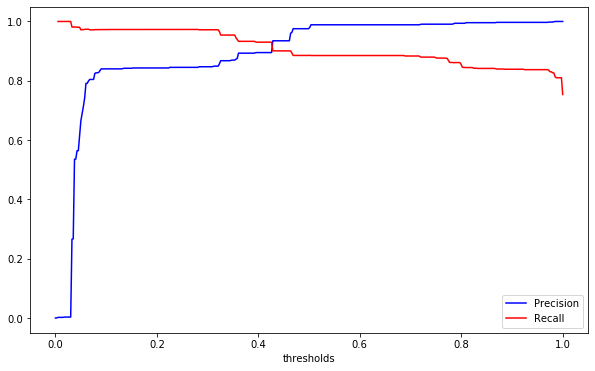

Best threshold is: 
0.42606516290726815


In [26]:
test_thresholds=np.linspace(0, 1, 400)
preds=[lr.predict(x_test_lr, threshold=threshold) for threshold in test_thresholds]
matrices = [confusion_matrix(y_test_lr, pred) for pred in preds]
precisions = [precision(cm) for cm in matrices]
recalls = [recall(cm) for cm in matrices]

plt.plot(test_thresholds, precisions, 'b', label='Precision')
plt.plot(test_thresholds, recalls, 'r', label='Recall')
plt.legend(loc="lower right")
plt.xlabel('thresholds')
plt.show()

# Find intersection point, biased towards recall
print("Best threshold is: ")
print(next(test_thresholds[idx-1] for idx, (p,r) in enumerate(zip(precisions,recalls)) if p > r))

##### Metrics

In [27]:
# LR with linear boundary 

predictions = lr.predict(x_test_lr)
cms['lr'] = confusion_matrix(y_test_lr, predictions)
print("Metrics with treshold = 0.5")
print_metrics(cms['lr'])

# Lower treshold

predictions = lr.predict(x_test_lr, threshold=0.424)
cms['lr_low_thres'] = confusion_matrix(y_test_lr, predictions)
print("Metrics with treshold = 0.424")
print_metrics(cms['lr_low_thres'])

Metrics with treshold = 0.5
[[958  24]
 [124 197]] 
 accuracy is 0.886415963161934 
 recall score is: 0.8853974121996303 
 precision score is:0.9755600814663951 
 specificity score is: 0.8914027149321267 
 F1 score is 0.9282945736434108
Metrics with treshold = 0.424
[[879 103]
 [ 66 255]] 
 accuracy is 0.8702993092862624 
 recall score is: 0.9301587301587302 
 precision score is:0.895112016293279 
 specificity score is: 0.7122905027932961 
 F1 score is 0.9122989102231447


### Multinomial logistic regression performance

In [28]:
accuracy_2r = lr2.score(x_test_quad, y_test_quad)
accuracy_3r = lr3.score(x_test_cubic, y_test_cubic)

print('quadratic accuracy is :', accuracy_2r)
print('cubic accuracy is :', accuracy_3r)

quadratic accuracy is : 0.8495778971603991
cubic accuracy is : 0.8434382194934766


##### Compare with the python library LogisticRegression

In [29]:
# fit data to LR model
lr = LogisticRegression()
lr.fit(x_train_quad, y_train_quad)

accuracy_sklr = lr.score(x_test_quad, y_test_quad)
print('accuracy is', accuracy_sklr)

accuracy is 0.8779739063699156


##### Metrics

In [30]:
# LR with quadratic boundary

predictions_2 = lr2.predict(x_test_quad)
cms['lr2'] = confusion_matrix(y_test_cubic, predictions_2)

print_metrics(cms['lr2'])

[[956  26]
 [170 151]] 
 accuracy is 0.8495778971603991 
 recall score is: 0.8490230905861457 
 precision score is:0.9735234215885947 
 specificity score is: 0.8531073446327684 
 F1 score is 0.9070208728652751


In [31]:
# LR with cubic boundary 

predictions_3 = lr3.predict(x_test_cubic)
cms['lr3'] = confusion_matrix(y_test_cubic, predictions_3)
print_metrics(cms['lr3'])

[[964  18]
 [186 135]] 
 accuracy is 0.8434382194934766 
 recall score is: 0.8382608695652174 
 precision score is:0.9816700610997964 
 specificity score is: 0.8823529411764706 
 F1 score is 0.9043151969981238


### Naive Bayes performance

In [32]:
accuracy_nb = model.score(x_test_nb, y_test_nb)
accuracy_nb

0.8365310821181888

##### Compare with the python library LogisticRegression

In [33]:
# Compare with sklearn
sk_model = BernoulliNB()
sk_model.fit(x_train_nb, y_train_nb)
sk_model.score(x_test_nb, y_test_nb)

0.8365310821181888

##### Metrics

In [34]:
# Naive Bayes

model = BernoulliNaiveBayes()
model.fit(x_train_nb, y_train_nb)

predictions_nb = model.predict(x_test_nb)
cms['nb'] = confusion_matrix(y_test_nb, predictions_nb)
print_metrics(cms['nb'])

[[860 122]
 [ 91 230]] 
 accuracy is 0.8365310821181888 
 recall score is: 0.9043112513144059 
 precision score is:0.8757637474541752 
 specificity score is: 0.6534090909090909 
 F1 score is 0.8898085876875323


# 5. Recap

In [35]:
col = ['Logistic Regression', 'LR lower threshold', 'polyRegression deg = 2', 'polyRegression deg = 3', 'Naive Bayes']
index = ['TP', 'FP', 'FN', 'TN','Precision', 'Recall', 'Accuracy', 'Specificity', 'F1']
performance = pd.DataFrame(index = index, columns = col)

methods = ['lr', 'lr_low_thres', 'lr2', 'lr3', 'nb']

performance.iloc[0:4, 0:5] = np.array([cms[method].flatten() for method in methods]).T


performance.loc['Precision',:] = [precision(cms[method]) for method in methods]
performance.loc['Recall',:] = [recall(cms[method]) for method in methods]
performance.loc['Accuracy',:] = [accuracy(cms[method]) for method in methods]
performance.loc['Specificity',:] = [specificity(cms[method]) for method in methods]
performance.loc['F1',:] = [f1_score(cms[method]) for method in methods]
performance

,Logistic Regression,LR lower threshold,polyRegression deg = 2,polyRegression deg = 3,Naive Bayes
TP,958,879,956,964,860
FP,24,103,26,18,122
FN,124,66,170,186,91
TN,197,255,151,135,230
Precision,0.97556,0.895112,0.973523,0.98167,0.875764
Recall,0.885397,0.930159,0.849023,0.838261,0.904311
Accuracy,0.886416,0.870299,0.849578,0.843438,0.836531
Specificity,0.891403,0.712291,0.853107,0.882353,0.653409
F1,0.928295,0.912299,0.907021,0.904315,0.889809


### Compare with original study findings

In [36]:
study = pd.read_csv("study_results.csv")
study = study.transpose()
study.columns = study.iloc[0]
study = study.drop(study.index[0])
display(study)

,XGBoost,GBM,SVM,Random Forest,Decision Tree
Precision,0.91,0.935,0.95,0.915,0.9025
Recall,0.9175,0.885,0.87,0.9,0.9025
F1 Score,0.91,0.905,0.905,0.91,0.9025
AUC,0.8475,0.8675,0.88,0.85,0.8475
LogLoss,4.4825,4.4725,4.4025,4.425,4.3475
